# This notebook is based on [dataset](https://www.kaggle.com/c/movie-review-sentiment-analysis-kernels-only/overview) by kaggle on Movie Review Sentiment Analysis from Rotten tomato. 

we are using keras and simple lstm model to train and validate model.

Feel free to use more complex models or use some more advance methods and architectures to increase the accuracy.

Here reviews are not full sentences but small phrases which makes this dataset quite interesting. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/movie-review-sentiment-analysis-kernels-only/test.tsv.zip
/kaggle/input/movie-review-sentiment-analysis-kernels-only/sampleSubmission.csv
/kaggle/input/movie-review-sentiment-analysis-kernels-only/train.tsv.zip


In [2]:
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,Embedding
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
#to print very long sentences in pandas df
pd.set_option('display.max_colwidth', -1)

In [4]:
!unzip  ../input/movie-review-sentiment-analysis-kernels-only/test.tsv.zip
!unzip  ../input/movie-review-sentiment-analysis-kernels-only/train.tsv.zip

Archive:  ../input/movie-review-sentiment-analysis-kernels-only/test.tsv.zip
  inflating: test.tsv                
Archive:  ../input/movie-review-sentiment-analysis-kernels-only/train.tsv.zip
  inflating: train.tsv               


In [5]:
!ls /kaggle/working

__notebook__.ipynb  __output__.json  test.tsv  train.tsv


In [6]:
train = pd.read_csv('/kaggle/working/train.tsv',sep = '\t')
test = pd.read_csv('/kaggle/working/test.tsv',sep = '\t')

In [7]:
sample_submsission =  pd.read_csv('/kaggle/input/movie-review-sentiment-analysis-kernels-only/sampleSubmission.csv')

In [8]:
train.head()

In [9]:
print('Total number of original reviews are:', len(pd.unique(train['SentenceId'])))

Total number of original reviews are: 8529


In [10]:
train.shape, test.shape

In [11]:
#let's check some random reviews
indices = np.random.randint(0,train.shape[0],5)
for index in indices:
    print(train['Phrase'][index])
    print(train['Sentiment'][index])

to congratulate himself for having the guts to confront it
4
The Bourne Identity should n't be half as entertaining as it is , but
3
the larger socio-political picture
2
humor and poignancy
3
people who owe
2


In [12]:
#These reviews are break down in small phrases 

In [13]:
#let's check some review by id
train[train['SentenceId']==10]

In [14]:
train[train['SentenceId']==187]

In [15]:
print('Average phrases per sentence in Train Data are: {:.0f}' .format(train.groupby(['SentenceId'])['Phrase'].count().mean()))
print('Average phrases per sentence in Test Data are: {:.0f}' .format(test.groupby(['SentenceId'])['Phrase'].count().mean()))

Average phrases per sentence in Train Data are: 18
Average phrases per sentence in Test Data are: 20


In [16]:
print('Total phrases in Train Data is {} and total sentences are {}' .format(train.shape[0],len(pd.unique(train['SentenceId']))))
print('Total phrases in Test Data is {} and total sentences are {}' .format(test.shape[0],len(pd.unique(test['SentenceId']))))

Total phrases in Train Data is 156060 and total sentences are 8529
Total phrases in Test Data is 66292 and total sentences are 3310


In [17]:
print('Average words in phrases in Train Data is {:f}' .format(train['Phrase'].apply(lambda x: len(x.split())).mean()))
print('Average words in phrases in Test Data is {:f}' .format(test['Phrase'].apply(lambda x: len(x.split())).mean()))

Average words in phrases in Train Data is 7.203364
Average words in phrases in Test Data is 6.678589


In [18]:
print('Maximum words in phrases in Train Data is {:f}' .format(train['Phrase'].apply(lambda x: len(x.split())).max()))
print('Maximum words in phrases in Test Data is {:f}' .format(test['Phrase'].apply(lambda x: len(x.split())).max()))

Maximum words in phrases in Train Data is 52.000000
Maximum words in phrases in Test Data is 56.000000


In [19]:
print('Minimum words in phrases in Train Data is {:f}' .format(train['Phrase'].apply(lambda x: len(x.split())).min()))
print('Minimum words in phrases in Test Data is {:f}' .format(test['Phrase'].apply(lambda x: len(x.split())).min()))

Minimum words in phrases in Train Data is 0.000000
Minimum words in phrases in Test Data is 0.000000


There is some empty data. 

In [20]:
#removing empty data from train data
to_remove = []
for i,row in train.iterrows():
    if(len(row['Phrase'].split())== 0):
        to_remove.append(i)
print(len(to_remove))
train.drop(to_remove,inplace = True)

1


In [21]:
#checking again minimun length of phrase
print('Minimum words in phrases in Train Data is {:f}' .format(train['Phrase'].apply(lambda x: len(x.split())).min()))

Minimum words in phrases in Train Data is 1.000000


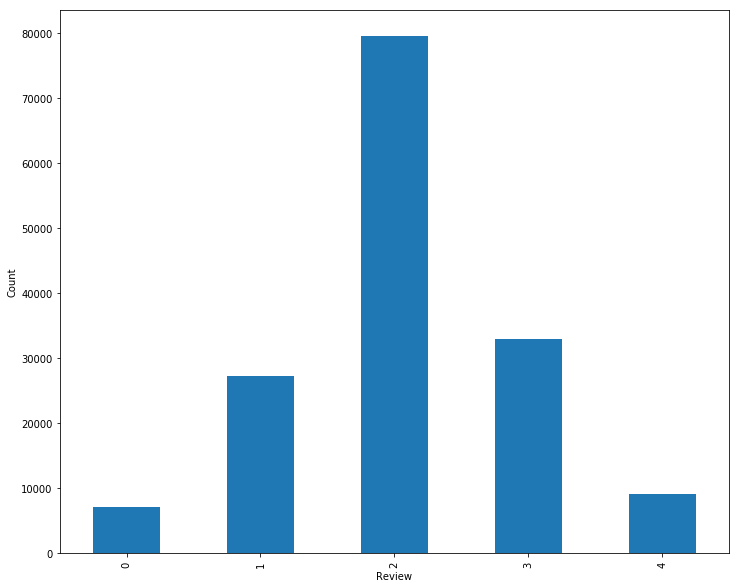

In [22]:
#let's plot number of reviews
plt.figure(figsize = (12,10))
train['Sentiment'].value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Review')
plt.ylabel('Count')
plt.show()

As expected most of the reviews are neutral as most of the sentences are small phrases.

## EDA on words and Preparing dataset for sequence models.

In [23]:
tokenizer = Tokenizer()

In [24]:
full_text = list(test['Phrase'].values) + list(train['Phrase'].values)

In [25]:
tokenizer.fit_on_texts(full_text)

In [26]:
#let's print some word counts
i = 0
for k,v in dict(tokenizer.word_counts).items():
    print(k,v)
    if i== 10:
        break
    i+=1

an 8950
intermittently 62
pleasing 100
but 7127
mostly 311
routine 168
effort 414
kidman 33
is 18798
really 1221
the 71814


In [27]:
#total phrases
print(tokenizer.document_count)

222351


In [28]:
#word index for one hot encoding
#let's print some
i = 0
for k,v in tokenizer.word_index.items():
    print(k,v)
    if i== 10:
        break
    i+=1

the 1
a 2
of 3
and 4
to 5
's 6
in 7
is 8
that 9
it 10
as 11


In [29]:
print('Total number of unique words in all of data : {}'.format( max(tokenizer.word_index.values())))

Total number of unique words in all of data : 17780


In [30]:
Most_used_words = dict(tokenizer.word_counts)
print('Most used words are:')
sorted(Most_used_words.items() ,key =lambda x:x[1], reverse = True)[:10]

Most used words are:


In [31]:
#dividing train data in training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(train['Phrase'],train['Sentiment'],test_size = .1)

In [32]:
print(X_train.shape,y_train.shape)
print(X_valid.shape,y_valid.shape)

(140453,) (140453,)
(15606,) (15606,)


In [33]:
X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_test = tokenizer.texts_to_sequences(test['Phrase'])

In [34]:
#example
print(X_train[0])

[18, 8, 24, 63, 2, 17, 102, 62, 394, 11, 1352, 1840]


In order to the input to rnn/lstm we need data of constant length. we can cut down some big sentences and pad down small sentences.

In [35]:
#let's use maximum sequence length of 40
max_len = 40
#using default pre padding. if phrase length is more than 40, it is truncated from starting.
X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_valid = sequence.pad_sequences(X_valid, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)
print(X_train.shape,X_valid.shape,X_test.shape)

(140453, 40) (15606, 40) (66292, 40)


In [36]:
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
print(y_train.shape,y_valid.shape)


(140453, 5) (15606, 5)


## Building and Training Model

In [37]:
max_features = 17780 #using all unique words
embedding_dim = 150
num_classes = 5
batch_size = 64

In [38]:
#callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
reduce_lr =  ReduceLROnPlateau(monitor='val_loss',verbose=1, factor=.1,patience=5)
checkpointer = ModelCheckpoint('model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

In [39]:
model = Sequential()
model.add(Embedding(max_features + 1, embedding_dim, input_length= max_len, mask_zero = True))        #input dim is max_features + 1 because 0 index is used in padding.
model.add(LSTM(100,dropout=0.6, recurrent_dropout=0.5,return_sequences=True))                         #returning full sequence for next layer, also using recurrent output
model.add(LSTM(64,dropout=0.6, recurrent_dropout=0.5,return_sequences=False))                         #returning only last output.  
model.add(Dense(num_classes,activation='softmax'))                                                    #final output

model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.01),metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 150)           2667150   
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 100)           100400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 2,810,115
Trainable params: 2,810,115
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid),epochs=50, batch_size=batch_size, verbose=1,callbacks = [es,reduce_lr,checkpointer])

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 140453 samples, validate on 15606 samples
Epoch 1/50
140453/140453 [==============================] - 253s 2ms/step - loss: 1.0050 - accuracy: 0.5939 - val_loss: 0.9038 - val_accuracy: 0.6279

Epoch 00001: val_loss improved from inf to 0.90380, saving model to model.hdf5
Epoch 2/50
140453/140453 [==============================] - 250s 2ms/step - loss: 0.9134 - accuracy: 0.6273 - val_loss: 0.9114 - val_accuracy: 0.6281

Epoch 00002: val_loss did not improve from 0.90380
Epoch 3/50
140453/140453 [==============================] - 247s 2ms/step - loss: 0.9002 - accuracy: 0.6323 - val_loss: 0.9053 - val_accuracy: 0.6314

Epoch 00003: val_loss did not improve from 0.90380
Epoch 4/50
140453/140453 [==============================] - 247s 2ms/step - loss: 0.8982 - accuracy: 0.6317 - val_loss: 0.9069 - val_accuracy: 0.6272

Epoch 00004: val_loss did not improve from 0.90380
Epoch 5/50
140453/140453 [==============================] - 244s 2ms/step - loss: 0.8967 - accuracy: 0.6340 - val

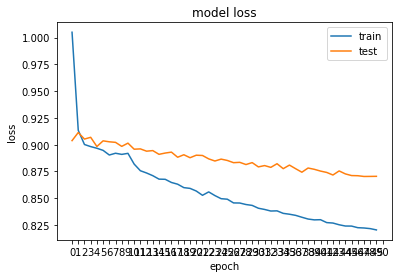

In [41]:
#let's plot losses

history = model.history.history
# list all data in history
#print(history.keys())
# summarize history for accuracy
plt.plot(history['loss'])
plt.plot(history['val_loss'])

ticks = list(range(len(history['loss'])+1)) # we need integers in x axis (epochs)
plt.xticks(ticks)

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Testing  Model

In [42]:
#loading the best weights
model.load_weights('model.hdf5')

In [43]:
predictions = model.predict(X_test)

In [44]:
y_test = predictions.argmax(axis = 1) 
y_test.shape

In [45]:
sample_submsission.Sentiment = y_test

In [46]:
sample_submsission.to_csv('submission.csv',index=False)

**we get accuracy of 62.14% on test data, which is quite good.** 